# Analyses post scrapping

Objectifs :
- on veut surveiller le nombre de concurrents
- ceux qui arrivent à vendre
- ceux qui changent de stratégie

In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [2]:
villes = ['Arcueil', 'Bourg-la-Reine', 'Cachan']
ma_description = 'Appartement entier calme pour JO 2024'
df = pickle.load(open('tous_les_logements.p', 'rb')).drop('texte', axis=1)
df = df[df.ville.isin(villes)].copy()

# On supprime ce logement, car il est enregistré avec 2 et avec 3 chambres à la fois :
df = df.query('description != "La maison de l’Éléphant"')

# Cet exemple montre qu'on a des doublons parfaits :
df[(df.description == 'Summer 2023 Cheerful 3-bedroom family home')]
clé = ['type', 'ville', 'description']
# Validation de la clé :
df = df.drop_duplicates(['date_enregistrement'] + clé)

# À une date d'enregistrement donné, ce qui fait l'unicité d'un logement est la combinaison
# de variables suivantes :
test = df.groupby(['date_enregistrement'] + clé).prix.nunique()
assert (test != 1).sum() == 0

def assigne_identifiant_logement(df, clé):
    """Assigne des id_logements"""
    mapping = df[clé].drop_duplicates().assign(id_logement=lambda df: range(1, len(df) + 1))
    mapping.loc[mapping.description == ma_description, 'id_logement'] = 0  # je me garde l'id 0 pour moi
    result = pd.merge(
        df, mapping, how='left', on=clé, validate='many_to_one'
    )
    result.insert(0, 'id_logement', result.pop('id_logement'))
    return result
df = assigne_identifiant_logement(df, clé)

date_cols = sorted(df.date_enregistrement.unique())
date_cols_str = [datetime.date.strftime(dt, '%d/%m/%Y') for dt in date_cols]
clé = ['id_logement'] + clé
print(df.shape)
df.tail(2)

(1371, 12)


,id_logement,date_enregistrement,type,ville,description,prix,note,nb_avis,nb_lits,nb_chambres,est_professionnel,est_nouveau
1369,137,2024-05-04,Hébergement,Arcueil,Maison Authentique,1852,4.81,53.0,NaN,NaN,False,False
1370,12,2024-05-04,Appartement,Cachan,Appartement - 2 pièces + Salon,1222,NaN,NaN,NaN,NaN,False,False


In [3]:
# Nombre de concurrents
df.groupby(['date_enregistrement', 'ville']).date_enregistrement.count().to_frame().unstack().T

date_enregistrement                 2023-12-20  2023-12-25  2024-01-06  \
                    ville                                                
date_enregistrement Arcueil                  6          15          17   
                    Bourg-la-Reine           8          10           7   
                    Cachan                  34          32          34   

date_enregistrement                 2024-01-13  2024-01-25  2024-01-31  \
                    ville                                                
date_enregistrement Arcueil                  6          15          16   
                    Bourg-la-Reine           5           6           7   
                    Cachan                  39          33          38   

date_enregistrement                 2024-02-10  2024-02-18  2024-02-24  \
                    ville                                                
date_enregistrement Arcueil                 20           9           6   
                    Bourg-la-Reine           6           1           2   
                    Cachan                  37          37          37   

date_enregistrement                 2024-03-02  2024-03-10  2024-03-17  \
                    ville                                                
date_enregistrement Arcueil                 25          32           8   
                    Bourg-la-Reine           7          12           7   
                    Cachan                  46          50          39   

date_enregistrement                 2024-03-22  2024-03-27  2024-04-06  \
                    ville                                                
date_enregistrement Arcueil                 14          48          15   
                    Bourg-la-Reine           5          16           6   
                    Cachan                  49          56          62   

date_enregistrement                 2024-04-14  2024-04-21  2024-05-04  
                    ville                                               
date_enregistrement Arcueil                 57          69          30  
                    Bourg-la-Reine          15          15          13  
                    Cachan                  65          66          61

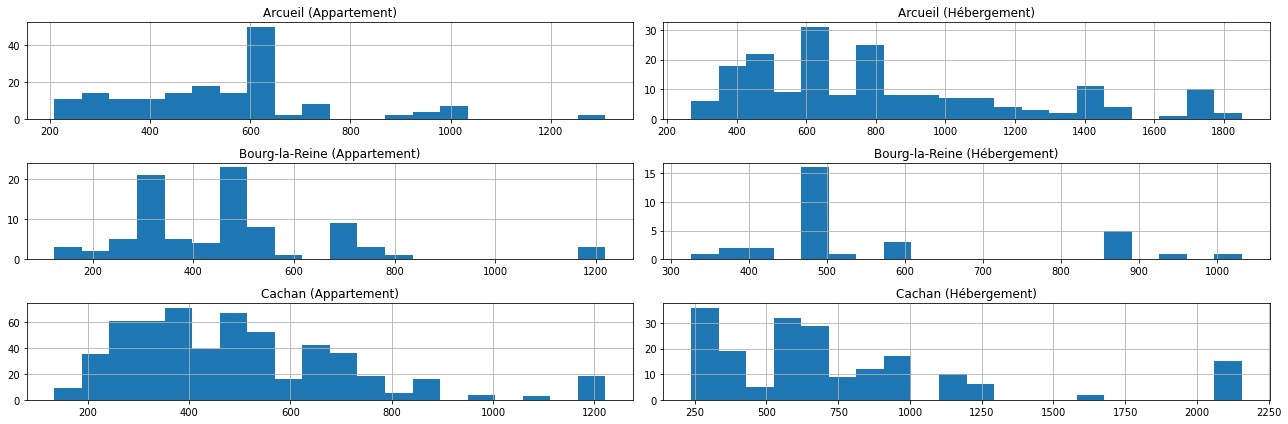

In [4]:
fig = plt.figure(figsize=(18, 6))
num_plot = 1
for ville in villes:
    vue = df[df.ville == ville]
    for type_ in ('Appartement', 'Hébergement'):
        fig.add_subplot(len(villes), 2, num_plot)
        plt.title(f'{ville} ({type_})')
        vue[vue.type == type_].prix.hist(bins=20)
        num_plot += 1
plt.tight_layout()

In [5]:
# Être nouveau augmente les prix
df.groupby('est_nouveau').prix.mean()

est_nouveau
False    596.321168
True     587.941818
Name: prix, dtype: float64

In [6]:
# Être professionnel aussi
df.groupby('est_professionnel').prix.mean()

est_professionnel
False    591.490566
True     685.369565
Name: prix, dtype: float64

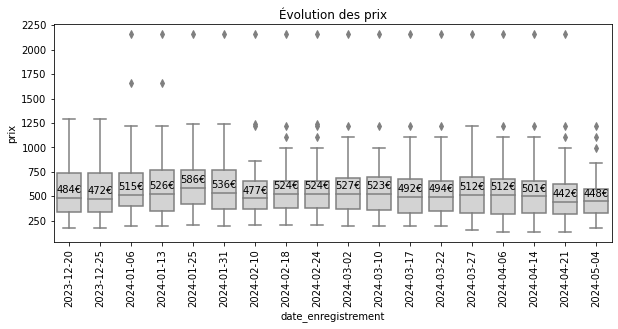

In [7]:
# Comment évoluent les prix ?
import seaborn as sns
plt.figure(figsize=(10, 4))
vue = df[df.ville == 'Cachan']


sns.boxplot(x=vue.date_enregistrement, y=vue.prix, color='lightgray')
médianes = vue.groupby('date_enregistrement').prix.median()
for i, médiane in enumerate(médianes):
    plt.text(i, médiane + 50, f'{médiane:.0f}€', ha='center')
plt.xticks(rotation=90)
plt.title('Évolution des prix');

## Suivi des logements dans le temps

In [8]:
df.sample(3)

,id_logement,date_enregistrement,type,ville,description,prix,note,nb_avis,nb_lits,nb_chambres,est_professionnel,est_nouveau
468,121,2024-02-24,Appartement,Cachan,Appartement 100 m. A 5 min RER B,637,NaN,NaN,NaN,NaN,False,False
839,88,2024-03-27,Hébergement,Arcueil,LA maison !,526,NaN,NaN,NaN,NaN,False,False
147,60,2024-01-06,Chambre,Arcueil,Séjournez chez Virginie Et François,896,4.93,30.0,NaN,NaN,False,False


In [9]:
def impute_trous(df, date_cols=date_cols):
    """
    Hypothèse : si un logement disparaît temporairement avant de réapparaître, c'est que je l'ai loupé dans mon scrapping.
    On peut donc légitimement imputer ces trous par la dernière valeur :
    """
    # Avant : pivot.query("id_logement == 27")
    df[date_cols] = df[date_cols].ffill(axis=1)
    for col in date_cols:
        df.loc[col < df.première_date_connue, col] = np.nan
        df.loc[col > df.dernière_date_connue, col] = np.nan
    # Après : pivot.query("id_logement == 27")
    

def make_pivot(df, date_cols=date_cols):
    pivot = df.pivot(columns=['date_enregistrement'], values='prix', index=clé)
    pivot.columns = list(pivot.columns)
    pivot = pivot.reset_index()
    
    pivot['première_date_connue'] = np.nan
    for col in date_cols:
        cond = pivot['première_date_connue'].isnull()
        cond &= pivot[col].notnull()
        pivot.loc[cond, 'première_date_connue'] = col

    pivot['dernière_date_connue'] = np.nan
    for col in date_cols[::-1]:
        cond = pivot['dernière_date_connue'].isnull()
        cond &= pivot[col].notnull()
        pivot.loc[cond, 'dernière_date_connue'] = col
    
    pivot['premier_prix_connu'] = pivot.filter(regex="202").bfill(axis=1).iloc[:, 0]
    pivot['dernier_prix_connu'] = pivot.filter(regex="202").ffill(axis=1).iloc[:, -1]
        
    impute_trous(pivot)
    pivot['loué'] = pivot['dernière_date_connue'] < date_cols[-2]
    return pivot
pivot = make_pivot(df, date_cols)
pivot.sample(3)

,id_logement,type,ville,description,2023-12-20,2023-12-25,2024-01-06,2024-01-13,2024-01-25,2024-01-31,...,2024-03-27,2024-04-06,2024-04-14,2024-04-21,2024-05-04,première_date_connue,dernière_date_connue,premier_prix_connu,dernier_prix_connu,loué
150,151,Appartement,Cachan,Bel appartement aux portes de Paris,NaN,NaN,NaN,NaN,NaN,NaN,...,689.0,689.0,689.0,689.0,689.0,2024-03-10,2024-05-04,689.0,689.0,False
70,71,Appartement,Bourg-la-Reine,Appt. 30 min de Paris centre de 53m2 balcon calme,NaN,NaN,489.0,489.0,489.0,489.0,...,489.0,489.0,489.0,489.0,489.0,2024-01-06,2024-05-04,489.0,489.0,False
87,88,Hébergement,Arcueil,LA maison !,NaN,NaN,NaN,684.0,684.0,684.0,...,526.0,526.0,526.0,526.0,NaN,2024-01-13,2024-04-21,684.0,526.0,False


In [10]:
def cachanais_qui_ont_modifié_leur_prix(pivot):
    changeurs = pivot[pivot[date_cols].nunique(axis=1) > 1]
    return changeurs
#cachanais_qui_ont_modifié_leur_prix(pivot)

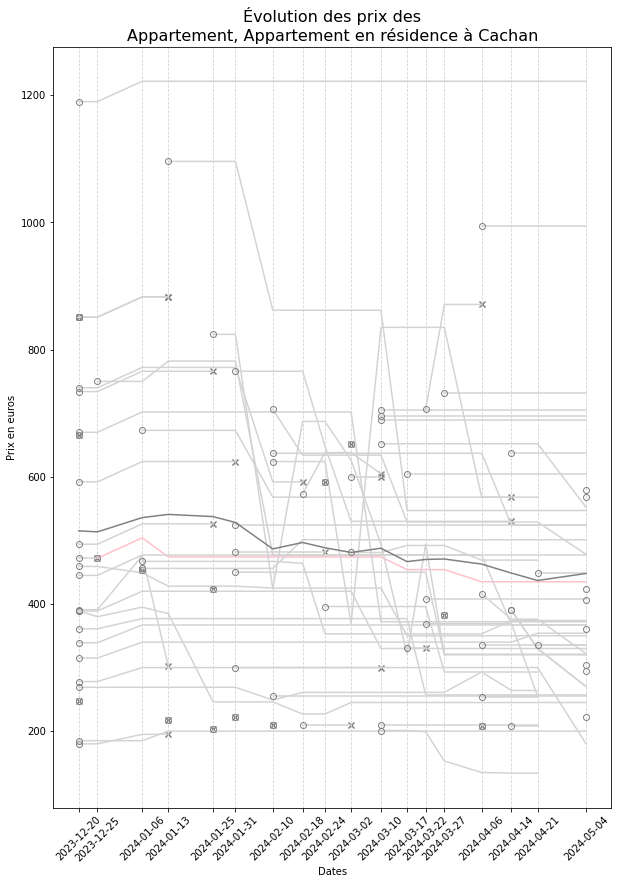

In [11]:
# Vision totale
ville = 'Cachan'
types = ('Appartement', 'Appartement en résidence')
vue = pivot.query(f"ville == '{ville}' and type in {types}")

plt.figure(figsize=(10, 14))
for i, row in vue.iterrows():
    color = 'pink' if row.description == ma_description else 'lightgrey'
    plt.plot(row[date_cols], color=color)
    # Un cercle pour les premiers prix connus
    plt.plot(row['première_date_connue'], row['premier_prix_connu'], marker='o', fillstyle='none', color='gray')
    # Une croix pour les loués :
    if row['loué']:
        plt.scatter(x=row['dernière_date_connue'],
                    y=row['dernier_prix_connu'],
                    marker="x", color='gray')
plt.plot(date_cols, vue[date_cols].mean().values, color='gray', label='mean')
plt.xticks(date_cols, rotation=45)
plt.ylabel('Prix en euros')
plt.xlabel('Dates')
plt.grid(axis='x', color='lightgrey', linestyle='--')
plt.title(f"Évolution des prix des\n{', '.join(types)} à {ville}", fontsize=16);

In [12]:
def make_stats(pivot, date_cols=date_cols):
    stats = dict()

    for date in date_cols[1:]:
        previous_date = date_cols[date_cols.index(date) - 1]
        stats[date] = dict()
        stats[date]['logements_réservables'] = pivot[date].notnull().sum()
        stats[date]['nb_nouveaux_logements'] = (pivot.première_date_connue == date).sum()
        stats[date]['nb_logements_loués'] = ((pivot.dernière_date_connue == previous_date) & (pivot.loué)).sum()
        stats[date]['solde'] = stats[date]['nb_nouveaux_logements'] - stats[date]['nb_logements_loués']

        # Evolution des prix :
        stats[date]['prix_en_baisse'] = (pivot[previous_date] > pivot[date]).sum()
        stats[date]['prix_en_augmentation'] = (pivot[previous_date] < pivot[date]).sum()
        stats[date]['prix_stable'] = (pivot[previous_date] == pivot[date]).sum()

    return pd.DataFrame(stats)

stats = make_stats(pivot.query("ville == 'Cachan'"), date_cols=date_cols)
stats

,2023-12-25,2024-01-06,2024-01-13,2024-01-25,2024-01-31,2024-02-10,2024-02-18,2024-02-24,2024-03-02,2024-03-10,2024-03-17,2024-03-22,2024-03-27,2024-04-06,2024-04-14,2024-04-21,2024-05-04
logements_réservables,34,39,41,38,40,44,46,47,48,53,51,56,57,63,66,66,61
nb_nouveaux_logements,3,9,3,3,8,7,3,2,3,7,2,5,3,8,5,3,11
nb_logements_loués,3,4,1,6,6,3,1,1,2,2,4,0,2,2,2,3,0
solde,0,5,2,-3,2,4,2,1,1,5,-2,5,1,6,3,0,11
prix_en_baisse,1,2,4,2,1,8,3,2,4,6,5,3,5,6,9,6,8
prix_en_augmentation,0,22,4,0,1,0,3,1,1,1,1,1,1,1,1,1,0
prix_stable,30,6,30,33,30,29,37,42,40,39,43,47,48,48,51,56,42


In [13]:
def make_text_box(stats, date):
    logements_réservables = stats.loc['logements_réservables', date]
    entrants = stats.loc['nb_nouveaux_logements', date]
    sortants = stats.loc['nb_logements_loués', date]
    prix_baisse = stats.loc['prix_en_baisse', date]
    prix_augmente = stats.loc['prix_en_augmentation', date]
    text_box = [
        f'{logements_réservables} logements',
        f"{entrants} entrants",
        f"{sortants} sortants",
        f"{prix_baisse} prix ➘",
        f"{prix_augmente} prix ➚"
    ]
    return '\n'.join(text_box)

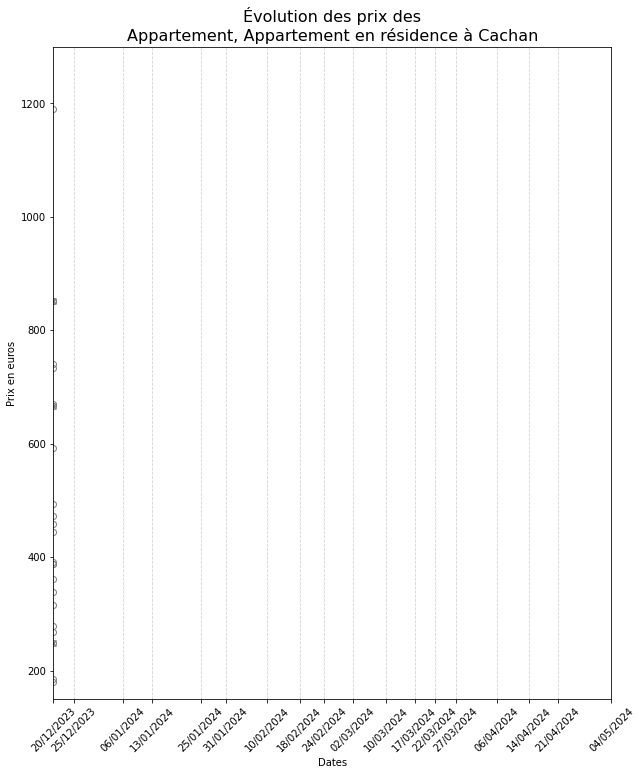

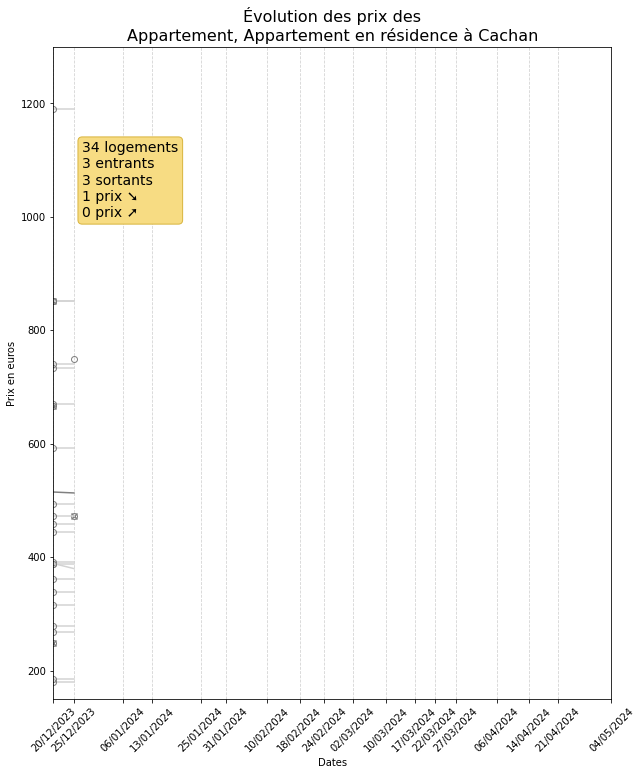

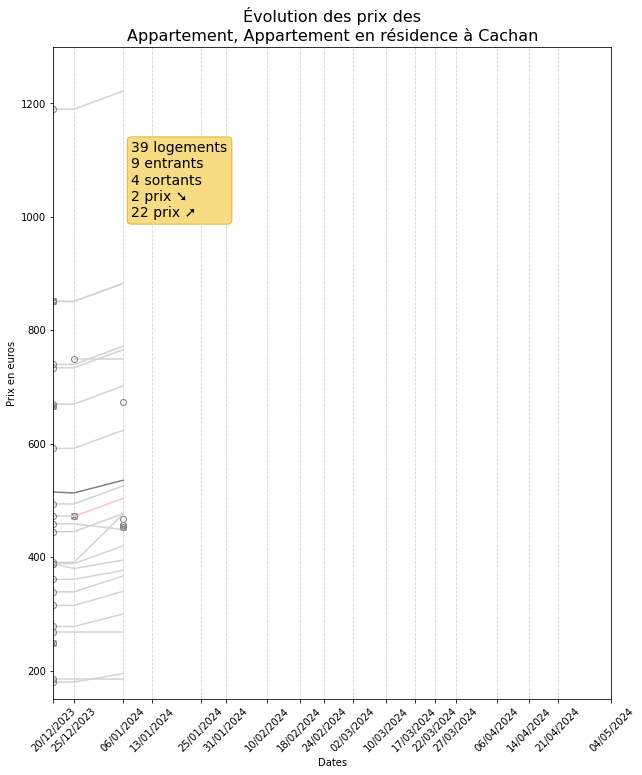

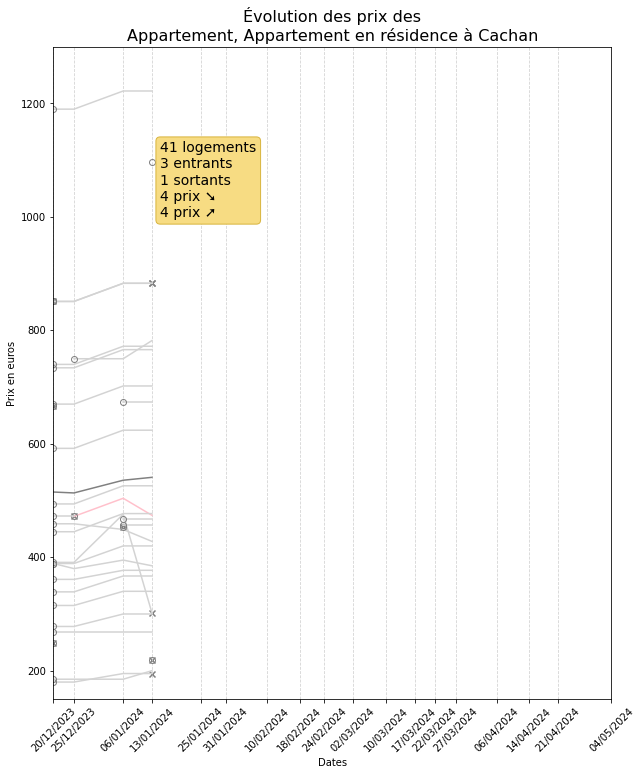

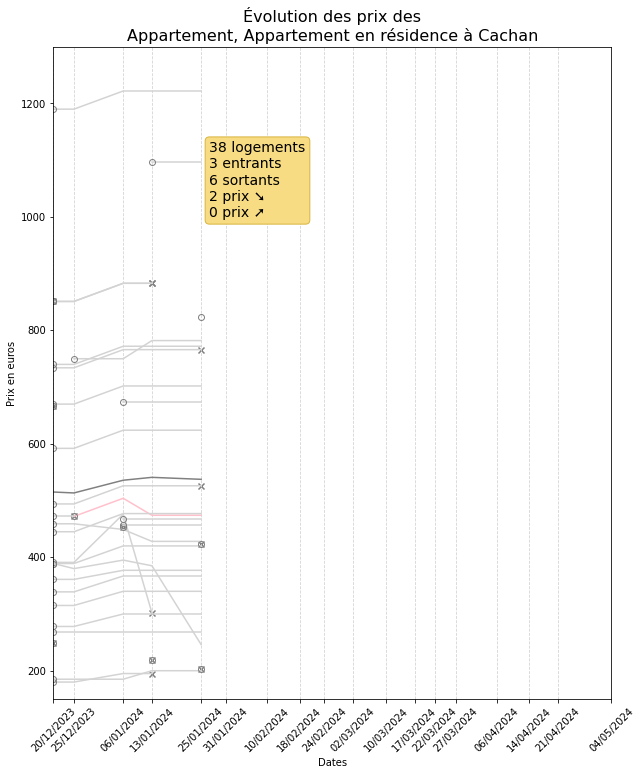

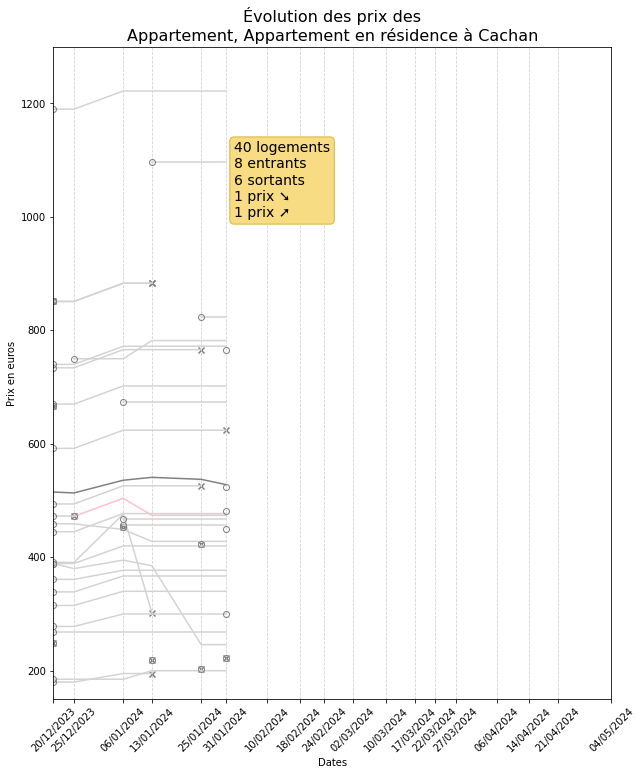

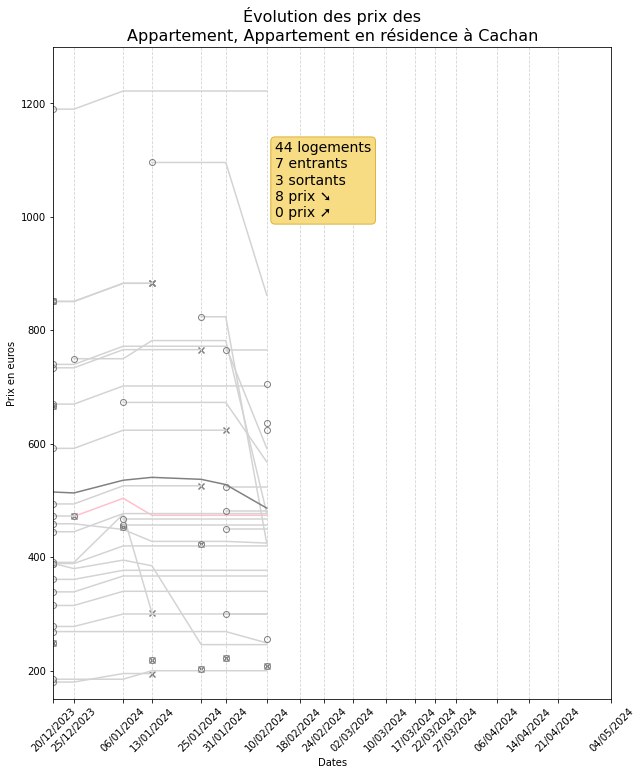

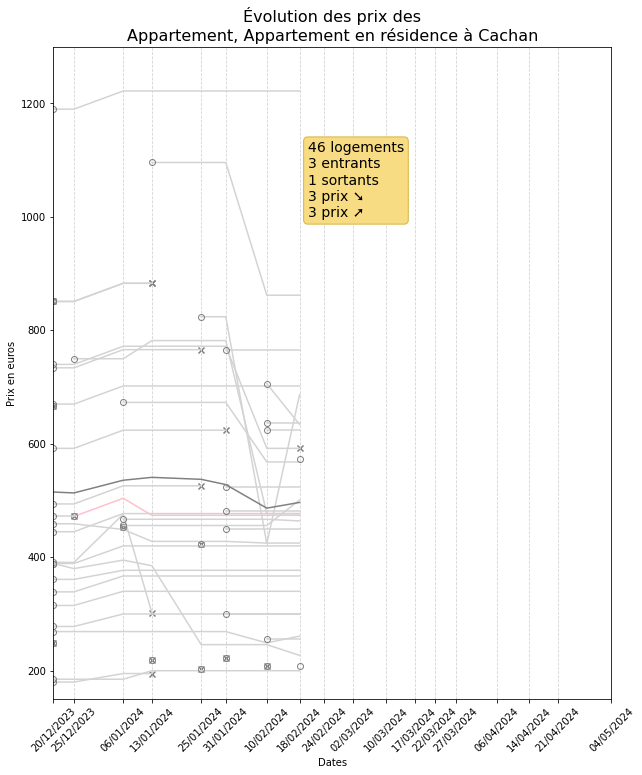

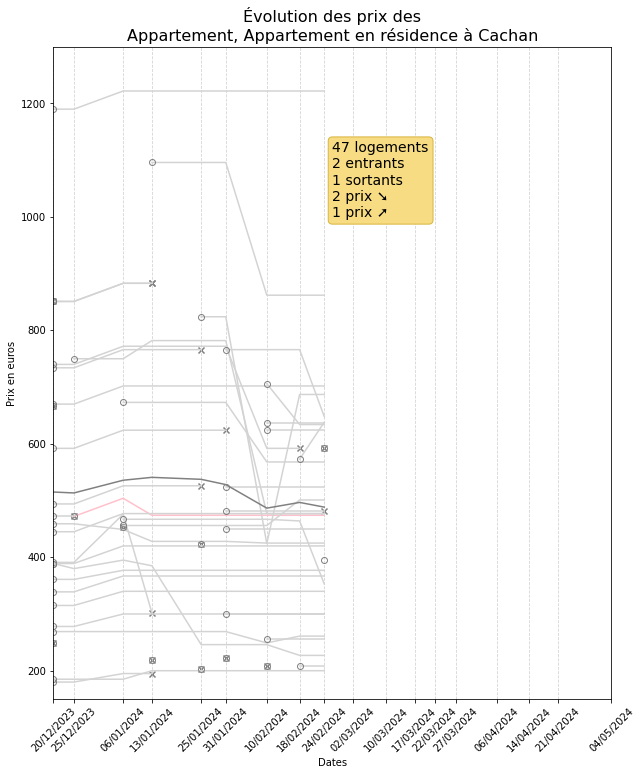

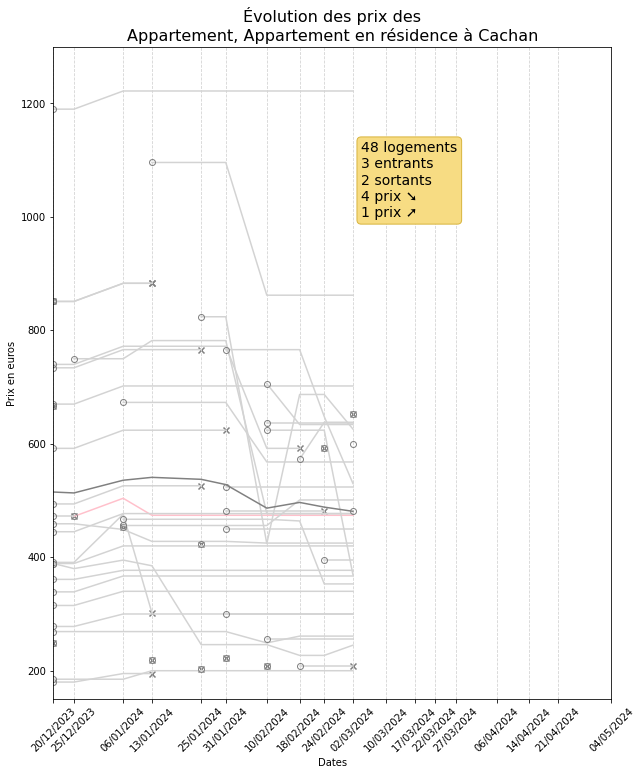

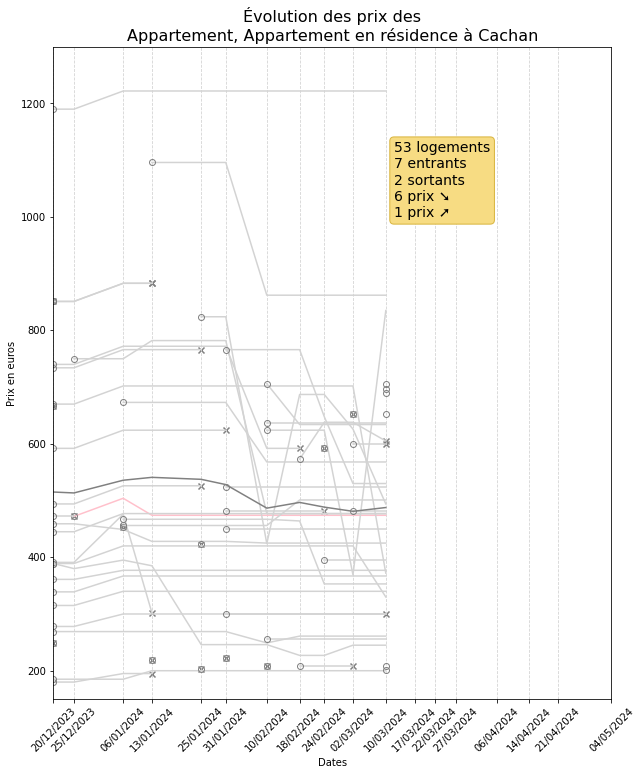

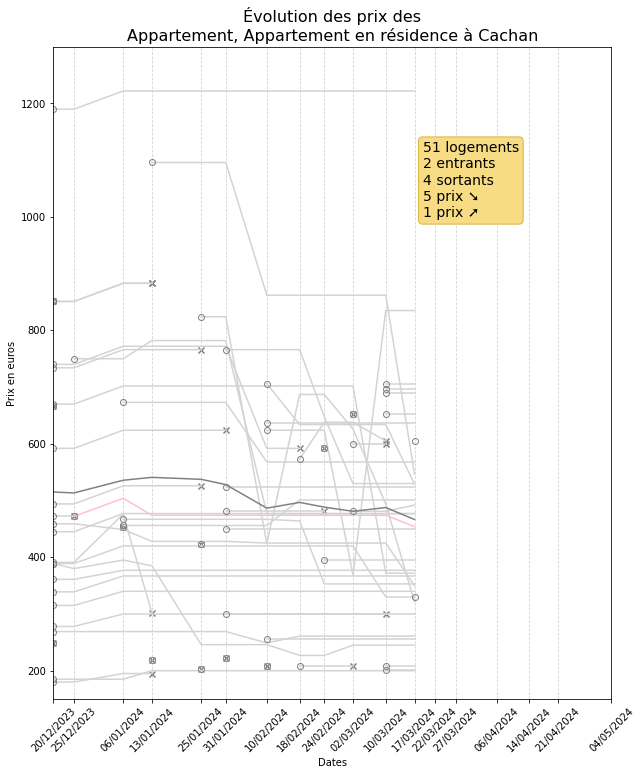

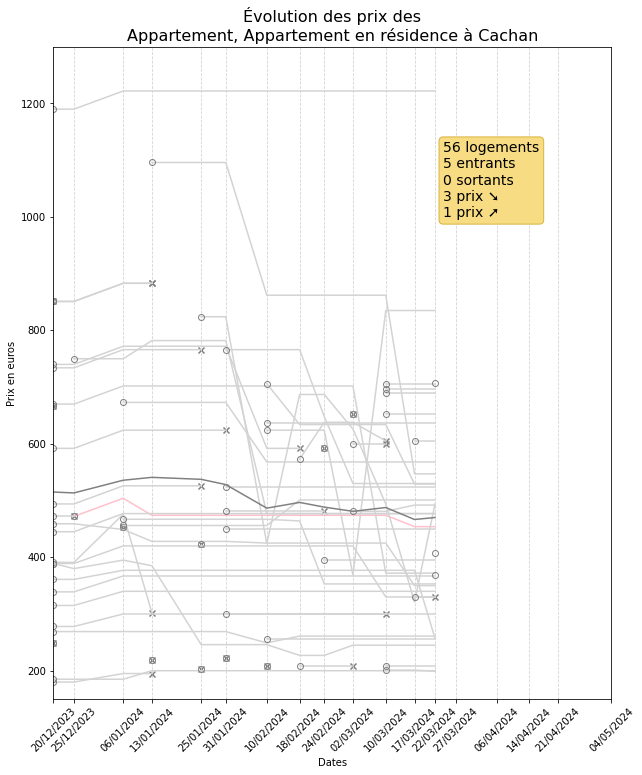

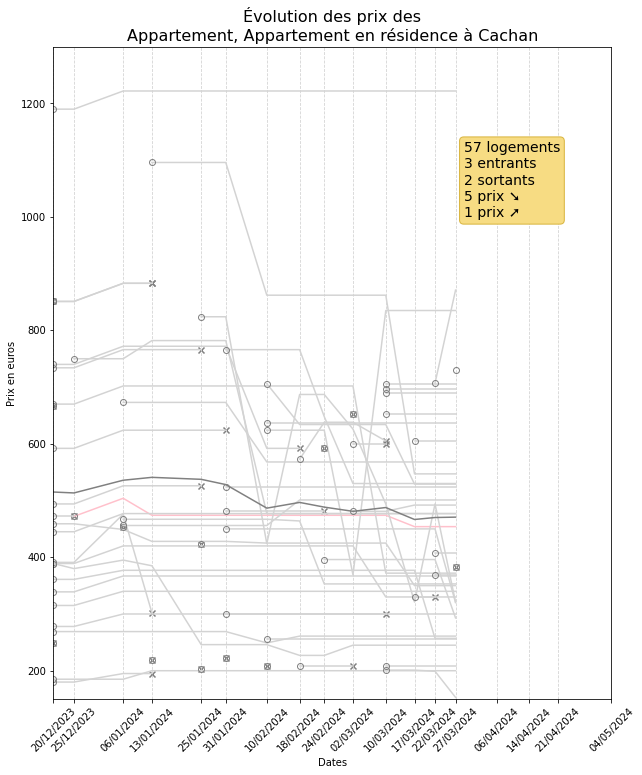

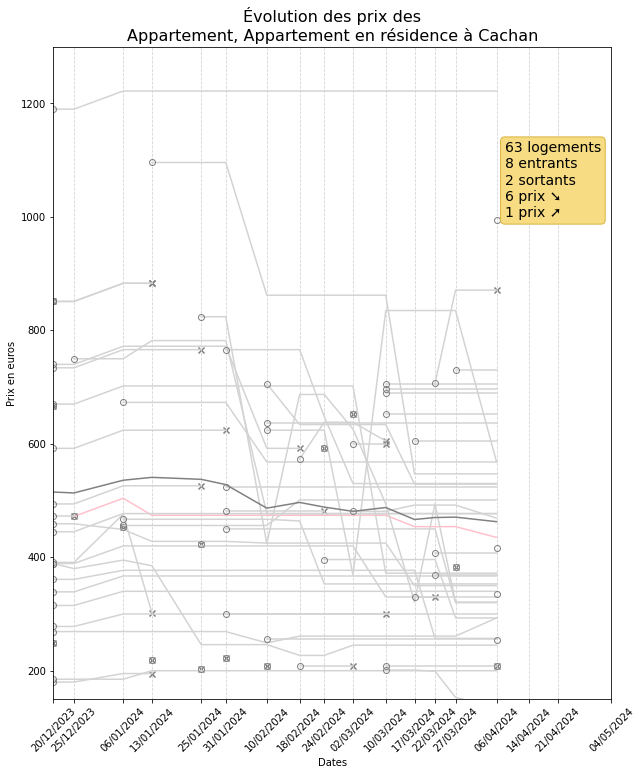

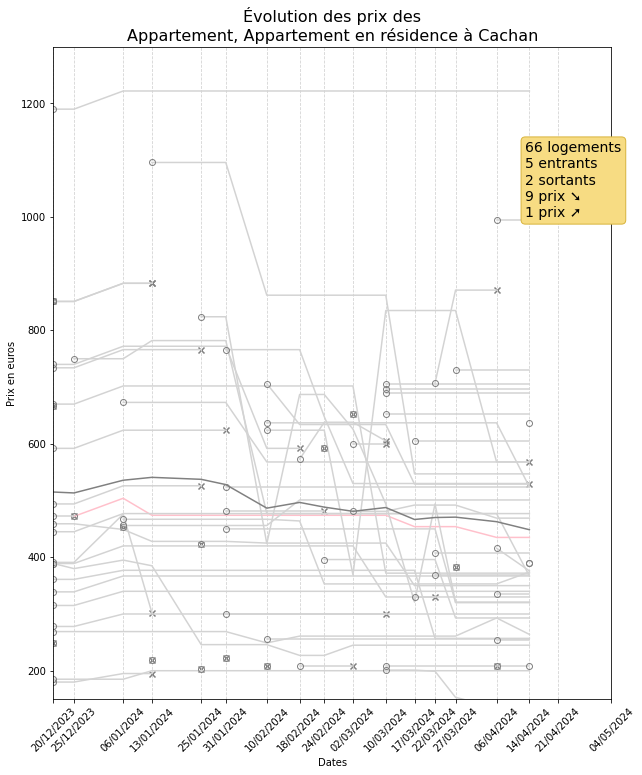

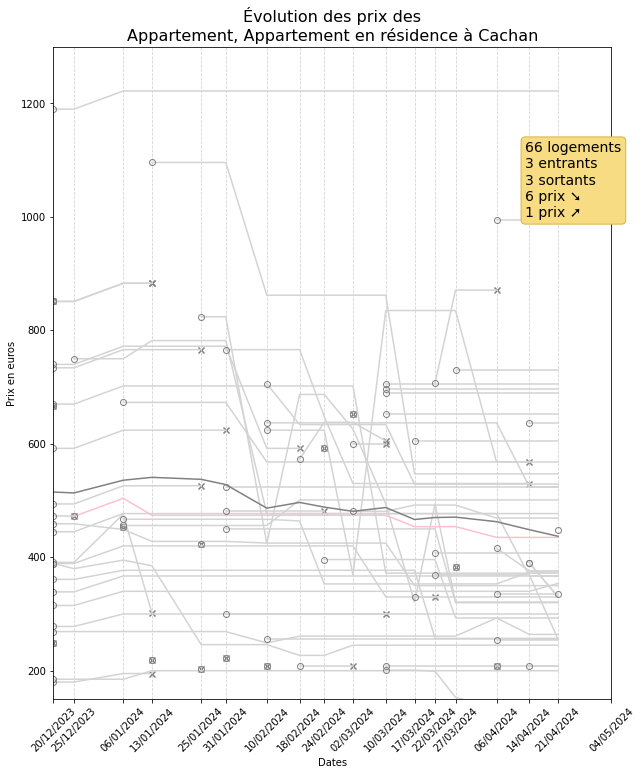

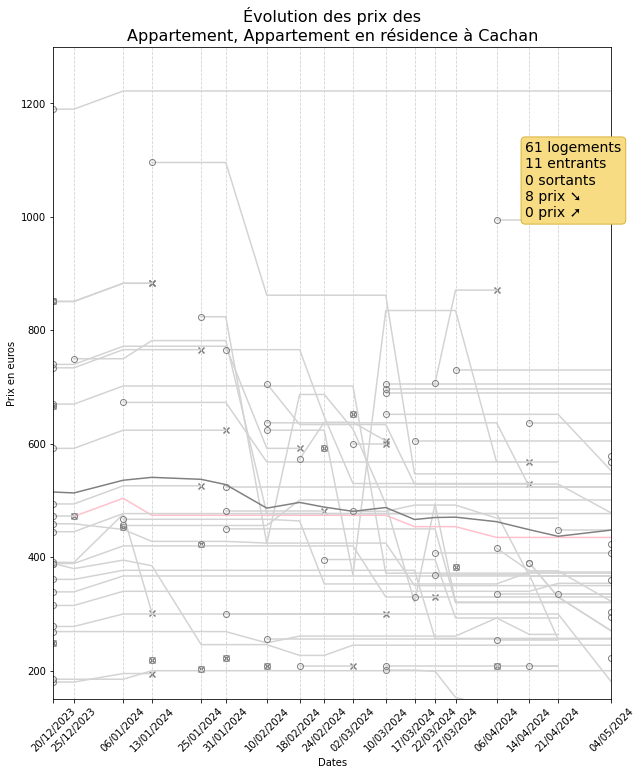

In [14]:
# Vision gif 
ville = 'Cachan'
types = ('Appartement', 'Appartement en résidence')
vue = pivot.query(f"ville == '{ville}' and type in {types}")


#camera = celluloid.Camera(fig)

for censure in range(len(date_cols)):
    fig = plt.figure(figsize=(10, 12))
    dt_censure = date_cols[censure]
    for i, row in vue.iterrows():
        color = 'pink' if row.description == ma_description else 'lightgrey'
        plt.plot(row[date_cols[:censure + 1]], color=color)
        # Un cercle pour les premiers prix connus
        if row['première_date_connue'] <= dt_censure:
            plt.plot(row['première_date_connue'],
                     row['premier_prix_connu'],
                     marker='o', fillstyle='none', color='gray')
        # Une croix pour les loués :
        if row['loué'] and row['dernière_date_connue'] <= dt_censure:
            plt.scatter(x=row['dernière_date_connue'],
                        y=row['dernier_prix_connu'],
                        marker="x", color='gray')
    plt.plot(date_cols[:censure + 1],
             vue[date_cols[:censure + 1]].mean().values,
             color='gray', label='mean')
    if dt_censure > date_cols[0]:
        text = make_text_box(stats, date=dt_censure)
        plt.text(
            min(
                dt_censure + pd.Timedelta(2, unit="days"),
                datetime.date.today() - pd.Timedelta(21, 'days')
            ),
            1000, text, size=14,
            bbox=dict(boxstyle="round", ec="#d9b53f", fc="#f7dc83")
        )

    plt.ylabel('Prix en euros')
    plt.xlabel('Dates')
    plt.xticks(date_cols, labels=date_cols_str, rotation=45)
    plt.ylim(150, 1300)
    plt.xlim(date_cols[0], date_cols[-1])
    plt.grid(axis='x', color='lightgrey', linestyle='--')
    plt.title(f"Évolution des prix des\n{', '.join(types)} à {ville}", fontsize=16)
    _ = plt.savefig(f'gif/gif_{censure}.png', facecolor='white');


## Annexes

In [122]:
# Recherche d'une clé primaire : 
variables_dynamiques = ['date_enregistrement', 'est_nouveau', 'note', 'nb_avis']
vue = df.drop(variables_dynamiques, axis=1).drop_duplicates()
vue[vue[clé].duplicated(keep=False)]

# --> les logements qui apparaissent sont ceux qui ont changé de stratégie de prix !
# --> la clé ['ville', 'type', 'description'] identifie donc un logement de façon unique

,type,ville,description,prix,nb_lits,nb_chambres,est_professionnel
41,Hébergement,Arcueil,La Maison Ensoleillée - 2 Chambres - RER B & M7,1425,NaN,NaN,False
57,Appartement,Cachan,2P a 10 min à pied du RER B,389,NaN,NaN,False
197,Appartement,Cachan,2P a 10 min à pied du RER B,380,NaN,NaN,False
239,Hébergement,Arcueil,La Maison Ensoleillée - 2 Chambres - RER B & M7,1355,NaN,NaN,False
